# RNOG_CNN_Detection Alpha

Mock model to try to identify average voltage SNR from a single station with 4 v-pols.

From station.json comment: 
> *a surface station with 4 downward facing LPDAs and 4 dipoles with 1GHz sampling, i.e., the bandwidth is 0-500MHz*

In [1]:
# imports
from torch.utils.data import DataLoader
from typing import Tuple, Dict, List
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from pathlib import Path
from torch import nn
import numpy as np
import random
import pickle
import torch
import sys

sys.path.append('/data/condor_shared/users/ssued/RNOGCnn')
import utils

torch.__version__

/data/i3home/ssued/venv_ubu22.04/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


'2.5.1+cu124'

In [2]:
# For developing, its better to use a small data size to train the model.
eventbatch = utils.obtain_evb('eventbatch.pkl')
# Select k random events from eventbatch
K = 500

eventbatch_k = dict(random.choices(list(eventbatch.items()), k=K))
print(f'Size of eventbatch = {len(eventbatch_k.keys())}')

Size of eventbatch = 468


In [3]:
# Save the events and create path variables
data_path = Path("data/")
event_path = data_path / 'eventbatch_k'

with open(event_path, 'wb') as file:
    pickle.dump(eventbatch_k, file)

In [4]:
# Double check that the events were saved:
with open(event_path, 'rb') as file:
    eventbatch_k_saved = pickle.load(file)

mean_snr_list_1 = [float(eventbatch_k_saved[key]['mean_SNR']) for key in eventbatch_k_saved.keys()]
mean_snr_list_2 = [float(eventbatch_k[key]['mean_SNR']) for key in eventbatch_k.keys()]
print(mean_snr_list_1)
print(mean_snr_list_2) # They should be the same

[3.536266677841344, 3.3185898798371447, 3.2303898203638366, 3.6364344750385813, 3.15863466284227, 3.081666269662814, 3.510931673925122, 3.2212338384871027, 3.465294164831982, 3.3698977003007604, 3.3585814685122934, 3.6033871275561755, 3.5633864836605484, 3.383539235246423, 3.553641539784822, 3.6264120050148474, 3.6202422026292282, 3.5034113346474722, 3.417067371837095, 3.8800021348956197, 3.323517093704602, 3.2063899057112653, 3.1622872895618284, 3.7306850449732796, 3.9330566659576194, 3.2982266680070884, 3.2450121151973184, 3.2741408768501197, 3.382122055464222, 3.1645535395502447, 3.5751783604487617, 3.391602601574358, 3.456546764195317, 4.21071327257763, 3.2938945897585614, 3.6499949393485727, 3.7260235370009824, 3.312515865629771, 3.488964198574982, 3.1504687638634294, 3.521709164444132, 3.8976197450724186, 3.4797460002498926, 3.429467939544103, 3.67227302998622, 3.058579223292739, 3.4038905709367424, 3.5870021651572115, 3.5169806636689724, 3.097569550805004, 3.361300930572881, 3.5

### Issue: For lack of redundancy, its better to have arrays rather than dictionaries:
```python
# I should convert: {0:{event_0},1:{event_1},2:{event_2}}
# into:             np.array([{event_0},{event_1},{event_2},...])
```
Although this should be fixed from the data creation steps, for now, I will simply convert eventbatch_k into a numpy array for testing

In [5]:
# Split the eventbatch_k into 75% training and 25% testing
# Calculate the split index
split_index = int(len(eventbatch_k) * 0.75)

# Split the eventbatch_k into 75% training and 25% testing
train_eventbatch = dict(list(eventbatch_k.items())[:split_index])
test_eventbatch = dict(list(eventbatch_k.items())[split_index:])

print(f'Size of train_eventbatch = {len(train_eventbatch.keys())}')
print(f'Size of test_eventbatch = {len(test_eventbatch.keys())}')

Size of train_eventbatch = 351
Size of test_eventbatch = 117


In [6]:
import numpy as np

eventbatch_k_arr = np.array([eventbatch_k[key] for key in eventbatch_k.keys()])

eventbatch_k_arr[0].keys()

dict_keys(['mean_SNR', 'bin_time', 'data'])

In [7]:
# Custom dataset class to work with dictionaries

class EventtoData(Dataset):
    """
    Custom Dataset class for handling event data.

    Attributes:
    -----------
    events : np.ndarray
        Array containing event data.
    n_channels : int
        Number of channels in the event data.
    n_bins : int
        Number of bins in the event data.
    bin_time : float
        Time duration of each bin.
    transform : callable, optional
        Optional transform to be applied on a sample.

    Methods:
    --------
    __len__():
        Returns the number of events.
    __getitem__(index: int) -> Dict:
        Returns a tuple (data, mean_SNR) for the given index.
    """
    def __init__(self, events=None, events_f=None, transform=None):
        if not events_f and not events:
            raise ValueError("Must include either events file or events to construct EventData object.")
        if events_f:
            with open(events_f, 'rb') as file:
                events_dict = pickle.load(file)
        else:
            events_dict = events

        # Must convert from dictionary to arrays
        self.events = np.array([events[key] for key in events.keys()])
        first_key = next(iter(events_dict))
        self.n_channels = events_dict[first_key]['data'].shape[0]
        self.n_bins = events_dict[first_key]['data'].shape[1]
        self.bin_time = events_dict[first_key]['bin_time'].item()
        self.transform = transform # deprecated for now

    def show_event(self, index : int):
        utils.plot_image(self.events[index])

    def mean_snr_of(self, index : int):
        return self.events[index]['mean_SNR'].item()

    def __len__(self) -> int:
        return len(self.events)

    # Must overwrite __getitem__():
    def __getitem__(self, index : int) -> Tuple:
        item_data_uncolored = self.events[index]['data']
        item_data = np.array([item_data_uncolored]) # Must add a color dimension
        item_snr = self.events[index]['mean_SNR']
        item = (item_data.astype('float32'),item_snr.astype('float32')) # Must convert double to float
        
        return item # Returns (data, mean_SNR)

In [8]:
# Initialize data and print out lengths:
train_data = EventtoData(train_eventbatch)
test_data = EventtoData(test_eventbatch)

print(f'Training data: {len(train_data)} events')
print(f'Testing data: {len(test_data)} events')

Training data: 351 events
Testing data: 117 events


In [9]:
data, snr = train_data.__getitem__(0)
data.dtype

dtype('float32')

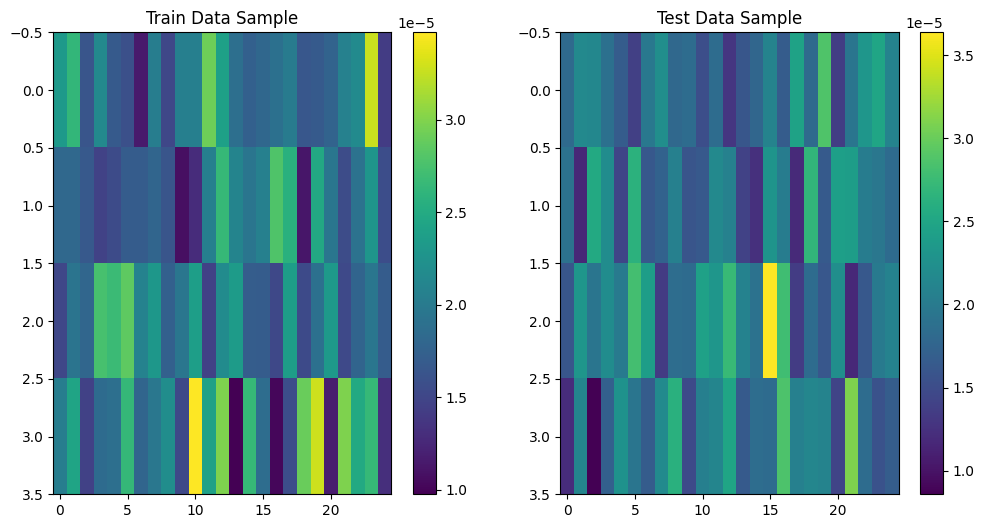

In [10]:
# Load into DataLoader:

BATCH_SIZE = 1 # Small batch size just to test batch size feature

train_data_loader = DataLoader(dataset = train_data, batch_size = BATCH_SIZE, shuffle=False)
test_data_loader = DataLoader(dataset = test_data, batch_size = BATCH_SIZE, shuffle = False)

a,b = next(iter(train_data_loader))
c,d = next(iter(test_data_loader))

a[0],c[0]

# Plot the tensors using a color map
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(a[0].squeeze(dim=0), cmap='viridis', aspect='auto')
plt.colorbar()
plt.title('Train Data Sample')

plt.subplot(1, 2, 2)
plt.imshow(c[0].squeeze(dim=0), cmap='viridis', aspect='auto')
plt.colorbar()
plt.title('Test Data Sample')

plt.show()

In [11]:
# Let there be light!
    
class RNOG_CNN_alpha(nn.Module):

    def __init__(self,input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        KERNEL_WIDTH = 2
        KERNEL_HEIGHT = 1
        KERNEL_SIZE = (KERNEL_HEIGHT,KERNEL_WIDTH)

        self.conv_block_1=nn.Sequential( # Blocks are collections of layers
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=KERNEL_SIZE,
                      stride=1), # Establish hyper parameters
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=KERNEL_SIZE,
                      stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=KERNEL_SIZE)
        )
        self.conv_block_2=nn.Sequential( # Blocks are collections of layers
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=KERNEL_SIZE,
                      stride=1), # Establish hyper parameters
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=KERNEL_SIZE,
                      stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=KERNEL_SIZE)
        )
        self.classifier=nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*16, # Will require additional care when changin bin sizes
                      out_features=output_shape),
            nn.Flatten(0)
        )

    def forward(self,x):
        x = self.conv_block_1(x)
        #print(x.shape)
        x = self.conv_block_2(x)
        #print(x.shape)
        x = self.classifier(x)
        return x

In [12]:
# Check that dimensions work

model_test = RNOG_CNN_alpha(1,10,1)

X, Y = next(iter(train_data_loader))
print(X.shape)
with torch.inference_mode():
    Y_pred = model_test(X)

#Y = Y.view_as(Y_pred)  # Reshape Y to match Y_pred

print(Y)
print(Y_pred)

#from torchinfo import summary
#summary(model_test, input_size=[1, 1, 4, 25]) # do a test pass through of an example input size

torch.Size([1, 1, 4, 25])
tensor([3.5363])
tensor([-0.0653])


In [13]:
# Setup device agnostic code
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### Training and Testing Steps

In [14]:
# Train_step function:

def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss
    train_loss = 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)
        #Y = y.view_as(y_pred)

        # 2. Calculate and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Adjust metrics to get average loss per batch
    train_loss = train_loss / len(dataloader)
    return train_loss

In [15]:
# Test step function:

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test values
    test_loss = 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred = model(X)
            #Y = y.view_as(test_pred)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred, y)
            test_loss += loss.item()
            
    # Adjust metrics to get average loss per batch 
    test_loss = test_loss / len(dataloader)
    return test_loss

In [16]:
# Train function (Combines both steps)

from torch.optim.lr_scheduler import ExponentialLR
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          scheduler: torch.optim.lr_scheduler.LRScheduler,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
               "test_loss": [],
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss = train_step(model=model,
                                dataloader=train_dataloader,
                                loss_fn=loss_fn,
                                optimizer=optimizer)
        test_loss = test_step(model=model,
                              dataloader=test_dataloader,
                              loss_fn=loss_fn)
        scheduler.step()

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch} | "
            f"train_loss: {train_loss:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"learning_rate: {scheduler.get_last_lr()}"
        )

        # 5. Update results dictionary
        # Ensure all data is moved to CPU and converted to float for storage
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)

    # 6. Return the filled results at the end of the epochs
    return results

In [17]:
# Set number of epochs
NUM_EPOCHS = 50

# Recreate an instance of TinyVGG
model_0 = RNOG_CNN_alpha(input_shape=1, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=1)

# Setup loss function and optimizer
#loss_fn = nn.MSELoss()
loss_fn = nn.HuberLoss()
#loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.1)
scheduler = ExponentialLR(optimizer, gamma=0.9)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0 
model_0_results = train(model=model_0, 
                        train_dataloader=train_data_loader,
                        test_dataloader=test_data_loader,
                        optimizer=optimizer,
                        scheduler=scheduler,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0 | train_loss: 0.3349 | test_loss: 0.3094 | learning_rate: [0.009000000000000001]
Epoch: 1 | train_loss: 0.2739 | test_loss: 0.3149 | learning_rate: [0.008100000000000001]
Epoch: 2 | train_loss: 0.2665 | test_loss: 0.3107 | learning_rate: [0.007290000000000001]
Epoch: 3 | train_loss: 0.2671 | test_loss: 0.3140 | learning_rate: [0.006561000000000002]
Epoch: 4 | train_loss: 0.2631 | test_loss: 0.3084 | learning_rate: [0.005904900000000002]
Epoch: 5 | train_loss: 0.2607 | test_loss: 0.3078 | learning_rate: [0.005314410000000002]
Epoch: 6 | train_loss: 0.2590 | test_loss: 0.3087 | learning_rate: [0.004782969000000002]
Epoch: 7 | train_loss: 0.2578 | test_loss: 0.3097 | learning_rate: [0.004304672100000002]
Epoch: 8 | train_loss: 0.2570 | test_loss: 0.3104 | learning_rate: [0.003874204890000002]
Epoch: 9 | train_loss: 0.2563 | test_loss: 0.3110 | learning_rate: [0.003486784401000002]
Epoch: 10 | train_loss: 0.2558 | test_loss: 0.3115 | learning_rate: [0.003138105960900002]
Epoch: 11

### Evaluate the model!

In [18]:
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               device: torch.device = device):
    """Evaluates a given model on a given dataset.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        device (str, optional): Target device to compute on. Defaults to device.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss = 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to the target device
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            y = y.view_as(y_pred)  # Reshape y to match y_pred
            loss += loss_fn(y_pred, y)
        
        # Scale loss and acc
        loss /= len(data_loader)
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item()}

In [19]:
model_0_eval=eval_model(model=model_0,
                           data_loader=train_data_loader,
                           loss_fn=loss_fn,
                           device=device)

model_0_eval

{'model_name': 'RNOG_CNN_alpha', 'model_loss': 0.25088751316070557}

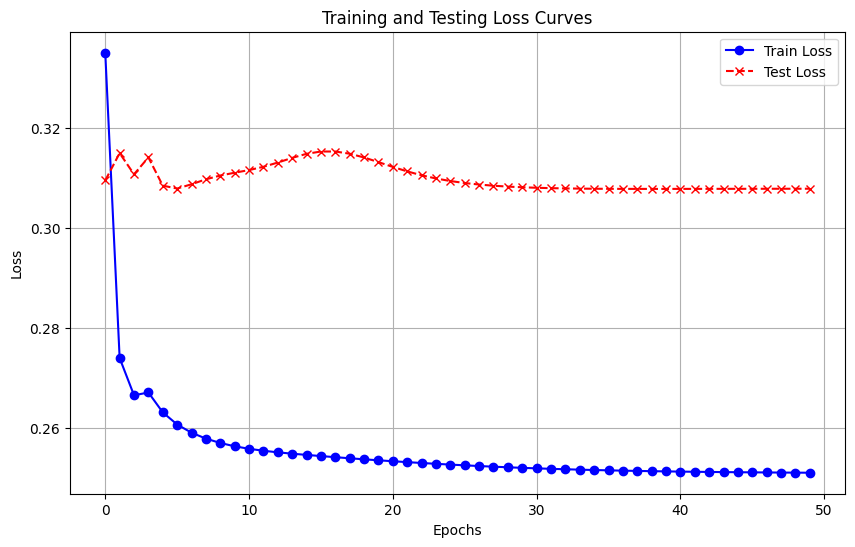

In [20]:
# Plot loss curves with improved aesthetics:
epochs = np.arange(NUM_EPOCHS)
train_loss = model_0_results['train_loss']
test_loss = model_0_results['test_loss']

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Train Loss', color='blue', linestyle='-', marker='o')
plt.plot(epochs, test_loss, label='Test Loss', color='red', linestyle='--', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

### Lets see how well it can predict a new voltage!

In [21]:
# Select 20 random events from eventbatch
random_events = dict(random.choices(list(eventbatch.items()), k=20))

random_data = EventtoData(random_events)

random_dataloader = DataLoader(random_data,1,False)

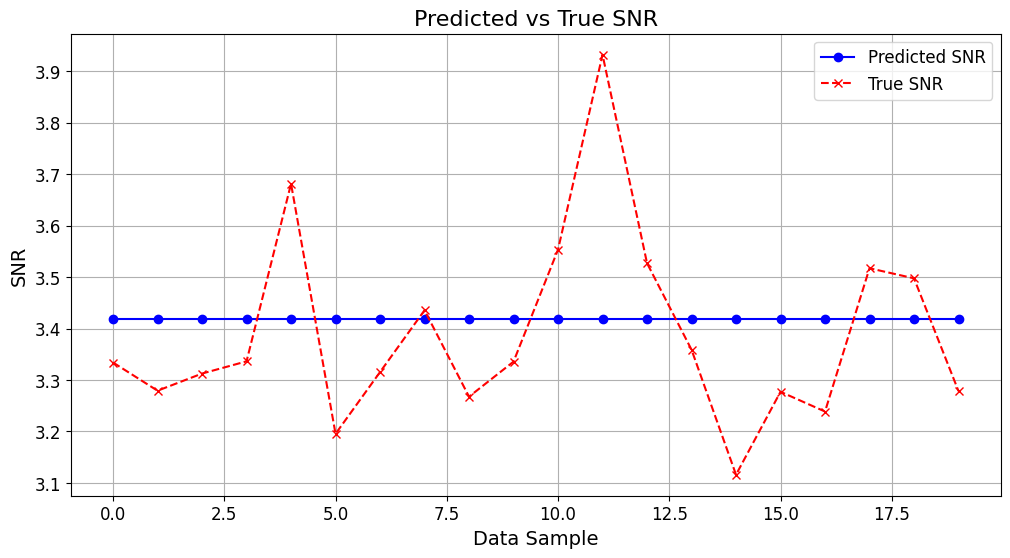

In [22]:
def make_predictions(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, device: torch.device = device, plot: bool = False):
    predictions = []
    model.eval()
    with torch.inference_mode():
        for data, snr in dataloader:
            data = data.to(device)
            pred = model(data)
            predictions.append((pred.item(), snr.item()))

    if plot:
        pred_values, true_values = zip(*predictions)
        samples = np.arange(len(pred_values))

        plt.figure(figsize=(12, 6))
        plt.plot(samples, pred_values, label='Predicted SNR', marker='o', linestyle='-', color='blue')
        plt.plot(samples, true_values, label='True SNR', marker='x', linestyle='--', color='red')
        plt.xlabel('Data Sample', fontsize=14)
        plt.ylabel('SNR', fontsize=14)
        plt.title('Predicted vs True SNR', fontsize=16)
        plt.legend(fontsize=12)
        plt.grid(True)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.show()

    return predictions

preds = make_predictions(model_0, random_dataloader, device=device, plot=True)
#print(preds)
